In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def import_data(detector:str, mass_ratio):
    """Import data computed from scr/rayleigh_criterion_two_modes.py
    
    Parameters
    ----------
    detector : str
        Gravitational wave detector name. Must be {'LIGO', 'LISA',
        'CE' = 'CE2silicon', 'CE2silica', 'ET'}.
    mass_ratio : TYPE
        Binary black hole mass ratio. mass_ratio >= 1. This is used to
        determine the QNM parameters.
    
    Returns
    -------
    Pandas DataFrame
        Return DataFrame with the data
    """
    columns = ('mass',
               'redshift',
               'mode_0',
               'mode_1',
               'delta_freq',
               'sigma_freq_0',
               'sigma_freq_1',
               'delta_Q',
               'sigma_Q_0',
               'sigma_Q_1',
               'snr_0',
               'snr_1',
              )

    df = pd.read_csv(f'../data/rayleigh_criterion/{detector}_q_{mass_ratio}_Qfactor.dat', delimiter = "\t", comment="#", names=columns)
    df['mass_ratio'] = [mass_ratio]*len(df.mass)
    
    return df

def compute_criterion(data_frame):
    """Compute Rayleigh Criterion and SNR > 8 criterion.
    
    Parameters
    ----------
    data_frame : Pandas DataFrame
        DataFrame imported using 'import_data' function.
    """
    f_factor_1 = 4
    f_factor_2 = 0#.6
    tau_factor_1 = 10
    tau_factor_2 = 0#0.000005
    # compute rayleigh criterion
    data_frame['sigma_freq'] = data_frame.apply(lambda row: max(row.sigma_freq_0, row.sigma_freq_1), axis=1)
    data_frame['ray_freq'] = data_frame.apply(lambda row: np.sign(f_factor_1*row.delta_freq + f_factor_2/row.delta_freq - row.sigma_freq)+1, axis=1)

    data_frame['sigma_Q'] = data_frame.apply(lambda row: max(row.sigma_Q_0, row.sigma_Q_1), axis=1)
    data_frame['ray_Q'] = data_frame.apply(lambda row: np.sign(tau_factor_1*row.delta_Q + tau_factor_2/row.delta_Q - row.sigma_Q)+1, axis=1)

    data_frame['rayleigh'] = data_frame.apply(lambda row: np.sign(row.ray_freq and row.ray_Q), axis=1)

    # compute SNR > 8
    data_frame['snr_c_0'] = data_frame.apply(lambda row: np.sign(row.snr_0 - 8)+1, axis=1)
    data_frame['snr_c_1'] = data_frame.apply(lambda row: np.sign(row.snr_1 - 8)+1, axis=1)
    data_frame['snr'] = data_frame.apply(lambda row: np.sign(row.snr_c_0 and row.snr_c_1), axis=1)

    # both conditions
    data_frame['both'] = data_frame.apply(lambda row: np.sign(row.rayleigh and row.snr), axis=1)
    

In [3]:
def find_horizon_contour(data_frame, modes:tuple):
    """Compute horizon contour
    
    Parameters
    ----------
    data_frame : Pandas DataFrame
        Description
    modes : tuple
        2d tuple containig mode_0 and mode_1
    
    Returns
    -------
    list, list
        Returns masses and redshifts at the horizon arrays
    """
    pair = (data_frame.mode_0 == modes[0])&(data_frame.mode_1 == modes[1])&(data_frame.both==1)
    df_pair = data_frame[pair]
    X = df_pair.mass
    Y = df_pair.redshift
    Z = df_pair.both
    masses = sorted(set(X))
    redshifts = [max(Y[X==mass]) for mass in masses]
    if len(redshifts) > 0:
        redshifts[0] = min(Y[X==masses[0]]) 
        redshifts[-1] = min(Y[X==masses[-1]]) 
    
    return masses, redshifts

In [4]:
# df = import_data('LIGO', 1.5)
# compute_criterion(df)

In [5]:
# modes = ['(2,2,0)', '(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']
# horizons = pd.DataFrame()
# for comb in list(combinations(modes, 2)):
#     extra = {}
#     extra['masses'],  extra['redshifts'] = find_horizon_contour(df, comb)
#     extra['modes'] = [comb]*len(extra['masses'])
#     horizons = horizons.append(pd.DataFrame(extra))


In [6]:
# two_modes = []
# for mode in modes[1:]:
#     two_modes.append(('(2,2,0)',mode))

# colors = {
#     '(2,2,1) II': 'tab:red',
#     '(3,3,0)': 'tab:green',
#     '(4,4,0)': 'tab:blue',
#     '(2,1,0)': 'tab:orange',
# }
# for comb in two_modes:
#     df_plot = horizons[horizons.modes == comb]
#     plt.loglog(df_plot.masses, df_plot.redshifts, color = colors[comb[1]]);

# plt.ylim(1e-2,10)
# plt.show()
    

In [7]:
def plot_220_2modes(data_frame):
    modes = ['(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']
    two_modes = [('(2,2,0)',mode) for mode in modes]

    horizons = pd.DataFrame()
    for comb in two_modes:
        extra = {}
        extra['masses'],  extra['redshifts'] = find_horizon_contour(data_frame, comb)
        if len(extra['masses']) == 0:
            extra['masses'],  extra['redshifts'] = [np.nan]*2, [np.nan]*2
        extra['modes'] = [comb]*len(extra['masses'])
        horizons = horizons.append(pd.DataFrame(extra))

    colors = {
        '(2,2,1) II': 'tab:red',
        '(3,3,0)': 'tab:green',
        '(4,4,0)': 'tab:blue',
        '(2,1,0)': 'tab:orange',
    }
    for comb in two_modes:
        df_plot = horizons[horizons.modes == comb]
        plt.loglog(df_plot.masses, df_plot.redshifts, color = colors[comb[1]]);


In [8]:
# import all data
detectors = ["LIGO"]#, "ET", "CE", "LISA"]
ray = pd.DataFrame()

for q in [1.5, 10]:
    for detector in detectors:
        ray = ray.append(import_data(detector, q))
compute_criterion(ray)



In [9]:
ray = ray[ray.sigma_freq_0 != np.inf]
ray

,mass,redshift,mode_0,mode_1,delta_freq,sigma_freq_0,sigma_freq_1,delta_Q,sigma_Q_0,sigma_Q_1,...,mass_ratio,sigma_freq,ray_freq,sigma_Q,ray_Q,rayleigh,snr_c_0,snr_c_1,snr,both
0,12.621867,0.326257,"(2,2,0)","(2,2,1) II",24.113403,2.559743e+03,2.173108e+04,2.136776,1.434243e+02,1.290537e+02,...,1.5,2.173108e+04,0.0,1.434243e+02,0.0,0.0,0.0,0.0,0.0,0.0
1,10.000000,0.008913,"(2,2,0)","(2,2,1) II",40.008857,3.146606e+02,2.660580e+03,2.136776,9.970520e+00,8.122305e+00,...,1.5,2.660580e+03,0.0,9.970520e+00,2.0,0.0,0.0,0.0,0.0,0.0
2,23.484781,0.029593,"(2,2,0)","(2,2,1) II",16.693893,6.044015e+01,5.164695e+02,2.136776,5.136190e+00,4.933007e+00,...,1.5,5.164695e+02,0.0,5.136190e+00,2.0,0.0,0.0,0.0,0.0,0.0
3,17.216904,0.098259,"(2,2,0)","(2,2,1) II",21.347636,4.564675e+02,3.881994e+03,2.136776,2.937131e+01,2.704908e+01,...,1.5,3.881994e+03,0.0,2.937131e+01,0.0,0.0,0.0,0.0,0.0,0.0
4,32.034502,0.008913,"(2,2,0)","(2,2,1) II",12.489302,7.554068e+00,6.499215e+01,2.136776,8.846198e-01,8.791044e-01,...,1.5,6.499215e+01,0.0,8.846198e-01,2.0,0.0,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,10000.000000,0.726134,"(4,4,0)","(2,1,0)",0.936392,1.382761e+07,2.631431e+06,2.566062,1.244524e+09,8.186628e+08,...,10.0,1.382761e+07,0.0,1.244524e+09,0.0,0.0,0.0,0.0,0.0,0.0
53996,10000.000000,0.786616,"(4,4,0)","(2,1,0)",0.904693,2.134034e+07,4.020585e+06,2.566062,2.002351e+09,1.326668e+09,...,10.0,2.134034e+07,0.0,2.002351e+09,0.0,0.0,0.0,0.0,0.0,0.0
53997,10000.000000,0.852135,"(4,4,0)","(2,1,0)",0.872689,3.587777e+07,6.668490e+06,2.566062,3.510937e+09,2.262718e+09,...,10.0,3.587777e+07,0.0,3.510937e+09,0.0,0.0,0.0,0.0,0.0,0.0
53998,10000.000000,0.923112,"(4,4,0)","(2,1,0)",0.840481,3.688853e+07,6.704060e+06,2.566062,3.756611e+09,2.281906e+09,...,10.0,3.688853e+07,0.0,3.756611e+09,0.0,0.0,0.0,0.0,0.0,0.0


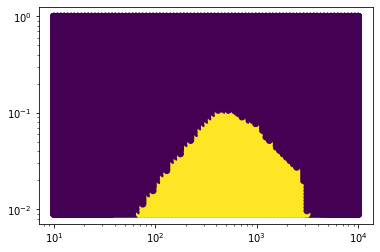

In [10]:
plt.scatter(ray.mass, ray.redshift, c = ray.both)
plt.xscale('log')
plt.yscale('log')

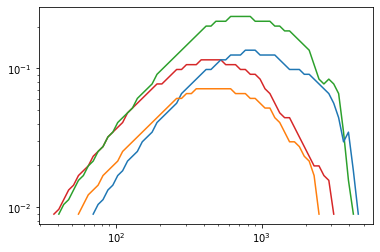

In [11]:
# plot all data
for detector in detectors:
    plot_220_2modes(ray)

In [12]:
def import_data_bayes(mass_ratio, mode):
    """Import data computed from scr/rayleigh_criterion_two_modes.py
    
    Parameters
    ----------
    detector : str
        Gravitational wave detector name. Must be {'LIGO', 'LISA',
        'CE' = 'CE2silicon', 'CE2silica', 'ET'}.
    mass_ratio : TYPE
        Binary black hole mass ratio. mass_ratio >= 1. This is used to
        determine the QNM parameters.
    
    Returns
    -------
    Pandas DataFrame
        Return DataFrame with the data
    """
    columns = ('mass',
               'redshift',
              )

    df = pd.read_csv(f'../data/bayes/horizon_{mass_ratio}_data_220_{mode}_model_220.dat', delimiter = "\t", comment="#", names=columns)
    df['modes'] = [mode]*len(df.mass)
    df['mass_ratio'] = [mass_ratio]*len(df.mass)
    return df

In [13]:
bayes = pd.DataFrame()
for q in [1.5, 10]:
    for mode in ['221', '330', '440', '210']:
        bayes = bayes.append(import_data_bayes(q, mode))

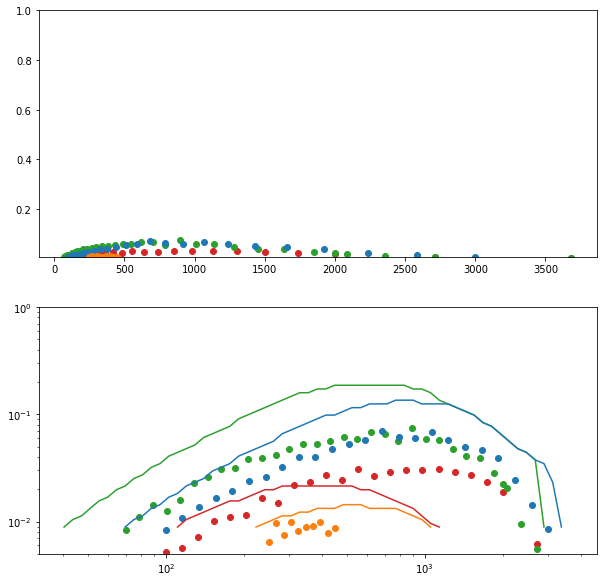

In [14]:
fig, ax = plt.subplots(2, figsize = [10,10])
i = 0

colors = {
    '221': 'tab:red',
    '330': 'tab:green',
    '440': 'tab:blue',
    '210': 'tab:orange',
}
plot_220_2modes(ray[ray['mass_ratio']==10])
for q in bayes.mass_ratio.unique():
    df_q_bayes = bayes[bayes.mass_ratio == 10]
    for mode in bayes.modes.unique():
        df_plot_bayes = df_q_bayes[df_q_bayes.modes == mode]
        ax[i].scatter(df_plot_bayes.mass, df_plot_bayes.redshift, label = mode, color = colors[mode])
    ax[i].set_ylim(5e-3, 1)
    print('')
        
    i += 1

In [15]:
ray

,mass,redshift,mode_0,mode_1,delta_freq,sigma_freq_0,sigma_freq_1,delta_Q,sigma_Q_0,sigma_Q_1,...,mass_ratio,sigma_freq,ray_freq,sigma_Q,ray_Q,rayleigh,snr_c_0,snr_c_1,snr,both
0,12.621867,0.326257,"(2,2,0)","(2,2,1) II",24.113403,2.559743e+03,2.173108e+04,2.136776,1.434243e+02,1.290537e+02,...,1.5,2.173108e+04,0.0,1.434243e+02,0.0,0.0,0.0,0.0,0.0,0.0
1,10.000000,0.008913,"(2,2,0)","(2,2,1) II",40.008857,3.146606e+02,2.660580e+03,2.136776,9.970520e+00,8.122305e+00,...,1.5,2.660580e+03,0.0,9.970520e+00,2.0,0.0,0.0,0.0,0.0,0.0
2,23.484781,0.029593,"(2,2,0)","(2,2,1) II",16.693893,6.044015e+01,5.164695e+02,2.136776,5.136190e+00,4.933007e+00,...,1.5,5.164695e+02,0.0,5.136190e+00,2.0,0.0,0.0,0.0,0.0,0.0
3,17.216904,0.098259,"(2,2,0)","(2,2,1) II",21.347636,4.564675e+02,3.881994e+03,2.136776,2.937131e+01,2.704908e+01,...,1.5,3.881994e+03,0.0,2.937131e+01,0.0,0.0,0.0,0.0,0.0,0.0
4,32.034502,0.008913,"(2,2,0)","(2,2,1) II",12.489302,7.554068e+00,6.499215e+01,2.136776,8.846198e-01,8.791044e-01,...,1.5,6.499215e+01,0.0,8.846198e-01,2.0,0.0,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,10000.000000,0.726134,"(4,4,0)","(2,1,0)",0.936392,1.382761e+07,2.631431e+06,2.566062,1.244524e+09,8.186628e+08,...,10.0,1.382761e+07,0.0,1.244524e+09,0.0,0.0,0.0,0.0,0.0,0.0
53996,10000.000000,0.786616,"(4,4,0)","(2,1,0)",0.904693,2.134034e+07,4.020585e+06,2.566062,2.002351e+09,1.326668e+09,...,10.0,2.134034e+07,0.0,2.002351e+09,0.0,0.0,0.0,0.0,0.0,0.0
53997,10000.000000,0.852135,"(4,4,0)","(2,1,0)",0.872689,3.587777e+07,6.668490e+06,2.566062,3.510937e+09,2.262718e+09,...,10.0,3.587777e+07,0.0,3.510937e+09,0.0,0.0,0.0,0.0,0.0,0.0
53998,10000.000000,0.923112,"(4,4,0)","(2,1,0)",0.840481,3.688853e+07,6.704060e+06,2.566062,3.756611e+09,2.281906e+09,...,10.0,3.688853e+07,0.0,3.756611e+09,0.0,0.0,0.0,0.0,0.0,0.0
